# Robust Lookup Table: AI Model

The goal of this notebook is to explore and experiment with a deep learning approach to create the Robust Lookup Table.

### Summary

* #### I. Generate fake scenarios & backends
* #### II. Design Deep learning model
* #### II. Train model


## I. Generate fake scenarios & backends

### I.1. Generate fake Scenarios


In [1]:
import random
import uuid
import hashlib
import numpy as np

In [2]:
# -- Fake scenarios

# ScenarioGeneratorConfig
# - size: the fixed size of the lookup table.
# - nBeforeBounds(x, y): nBefore ∈ [x, y].
# - nAfterBounds(x, y): nAfter ∈ [x, y].
# - variance(x, y): x < min(nBefore,nAfter)/max(nBefore,nAfter); y < max(nBefore,nAfter) - min(nBefore,nAfter)
# # - sizeBounds(x, y): lookup table size ∈ [x, y].
class ScenarioGeneratorConfig:
    size: int
    nBeforeBounds: (int, int)
    nAfterBounds: (int, int)
    variance: (float, int)
    # sizeBounds: (int, int)

    def __init__(
        self,
        size: int,
        nBeforeBounds: (int, int),
        nAfterBounds: (int, int),
        variance: (float, int),
        # sizeBounds: (int, int),
    ):
        if nBeforeBounds[1] > size or nAfterBounds[1] > size:
            raise Exception("nBeforeBounds and nAfterBounds cannot exceed size")

        self.size = size
        self.nBeforeBounds = nBeforeBounds
        self.nAfterBounds = nAfterBounds
        self.variance = variance
        # self.sizeBounds = sizeBounds

class Scenario:
    nBefore: int
    nAfter: int
    size: int

def validate_scenario(cfg: ScenarioGeneratorConfig, scenario: Scenario) -> bool:
    var = cfg.variance[0]
    delta = cfg.variance[1]

    _min = min([scenario.nBefore, scenario.nAfter])
    _max = max([scenario.nBefore, scenario.nAfter])
    _var = _min/_max
    _delta = _max - _min
    _sz = scenario.size

    return _var <= var and _delta <= delta and _max <= _sz and _min != _max

# creates a new scenario generator.
def new_scenario_generator(cfg):
    while True:
        scenario = Scenario()
        scenario.nBefore = random.randint(cfg.nBeforeBounds[0], cfg.nBeforeBounds[1])
        scenario.nAfter = random.randint(cfg.nAfterBounds[0], cfg.nAfterBounds[1])
        scenario.size = cfg.size
        # scenario.size = random.randint(cfg.sizeBounds[0], cfg.sizeBounds[1])

        if validate_scenario(cfg, scenario):
            yield scenario

In [3]:
nBeforeBounds = (3, 47)
nAfterBounds = (1, 47)
variance = (1.0, 10)
size = 47

cfg = ScenarioGeneratorConfig(size, nBeforeBounds, nAfterBounds, variance)
sc = new_scenario_generator(cfg)

for i in range(3):
    s = next(sc)
    print(s.__dict__)

{'nBefore': 13, 'nAfter': 20, 'size': 47}
{'nBefore': 8, 'nAfter': 1, 'size': 47}
{'nBefore': 39, 'nAfter': 42, 'size': 47}


### I.2. Generate fake Backends

In [4]:
class Backend:
    id: str
    h0: int
    h1: int
    h2: int
    h3: int

    def __init__(self):
        self.id = uuid.uuid4()
        
        _h = hashlib.sha256()
        _h.update(self.id.bytes_le)
        _b = _h.digest()
        self.h0 = int.from_bytes(_b[0:8], "little")
        self.h1 = int.from_bytes(_b[8:16], "little")
        self.h2 = int.from_bytes(_b[16:24], "little")
        self.h3 = int.from_bytes(_b[24:32], "little")

def list_permutation(l: list, size: int) -> list:
    _p = np.random.permutation(l)
    return _p[0:size]

# new_backend_generator takes a list of Scenario and yields a tuple of 2 Backends.
# The "before" list and the "after" list.
def new_backend_generator(scenarioGenerator):
    while True:
        sc = next(scenarioGenerator)
        _min = min([sc.nBefore, sc.nAfter])
        _max = max([sc.nBefore, sc.nAfter])
        l_min = []
        l_max = []

        # create the l_max backend array.
        l_max = [ Backend() for _ in range(_max) ]
        # for _ in range(_max):
        #     l_max.append(Backend())

        # create l_min array by randomly choosing _min elements of l_max.
        l_min = list_permutation(l_max, _min)

        # sort both arrays.
        l_max = sorted(l_max, key=lambda x: str(x.id))
        l_min = sorted(l_min, key=lambda x: str(x.id))
        
        if sc.nBefore < sc.nAfter:
            yield (l_min, l_max)
        else:
            # print([x.__dict__ for x in l_min])
            yield (l_max, l_min)

In [5]:
generator = new_backend_generator(new_scenario_generator(cfg))

for i in range(2):
    t = next(generator)
    print(f"- Before: len={len(t[0])} example_value={t[0][0].__dict__}")
    print(f"- After: len={len(t[1])} example_value={t[1][0].__dict__}")

- Before: len=4 example_value={'id': UUID('3d8d837c-cbe2-4fc4-9d0f-3deed74791b6'), 'h0': 6196111201378782721, 'h1': 17564946255403906249, 'h2': 527157904423247115, 'h3': 8806054692758717150}
- After: len=5 example_value={'id': UUID('3d8d837c-cbe2-4fc4-9d0f-3deed74791b6'), 'h0': 6196111201378782721, 'h1': 17564946255403906249, 'h2': 527157904423247115, 'h3': 8806054692758717150}
- Before: len=9 example_value={'id': UUID('4c89b4a8-865b-4dd9-b28e-44779fd7728c'), 'h0': 8091776817221854216, 'h1': 7266943767801356441, 'h2': 12464774367246404118, 'h3': 12210405371883127121}
- After: len=14 example_value={'id': UUID('0c90ad3d-6b67-4902-be4e-3a45dc934204'), 'h0': 16481765586869143473, 'h1': 14730238227097363266, 'h2': 2905179167379944899, 'h3': 11351632446967968410}


## II. Design Deep learning model

### Definitions

- Let `m` equal to the length of the lookup table: `m=len(lookup_table)`.
- Let `input` an array of length equal to m: `len(input)=m`. 
  - Each entry in `input` represents a backend.
- Let `h(i)` the hash of the i-th backend in `input`.
- Let `input[i]=h(i) % m`.
- Let `n` the number of backend actually represented in `input`.
  - Because: `nAfter != nBefore` and `max(nAfter,nBefore) <= m`.
- Let `output` a matrix of size `m*m`.
- Let `output[j]` the j-th row in the `output` matrix.
  - The j-th row of the `output` matrix represents the j-th entry of
     the lookup table.
- Let `o(i,j)` the i-th entry in `output[j]`.
  - `o(i,j)` is the probability of the i-th backend being mapped to the
     j-th entry of the lookup table.

### Input data

Problem 1: How to represent data in the inputs that is unmapped? 
- E.g. if the modulo of a hash is equal to 0, how should we represent entries
  that are out of bound.
- In other words, if `n=13` and `m=47`, how do we represent the entries with
  index in the range of [13:47]?

Definitions:
- Let `in-bound` entries the name of entries in the range [0:13].
- Let `out-of-bound` entries the name of entries in the range [13:47].

Solution:
- If we normalize `in-bound` entries as real numbers in [0,1], then we can
set `out-of-bound` entries to `-1`.
- Another solution would be to represent the input as a `m*m` matrix. 
  - The i-th row representing the i-th backend.
  - The j-th entry in i-th row representing the modulo of the hash of the i-th backend
  - If the j-th entry of the i-th row is equal to 1, it means 
  - If all entries of the i-th row are equal to 0, then it means there are no backends 
    there.

Problem 2: what if multiple backend have the same modulo?
- This is particularly problematic if 2 subsequent backends resolves to the same modulo
  and 1 of the backend becomes down. 
- In that case, there is not way to identify which backend was dropped from the model's
  point of view. 
- Hence there is a 50% chance to reaffect packets away from a healthy backend.

Solution:
- Compute multiple hash for each backend. Or split the 256-bit hash into 4 int64 and 
  compute 4 modulo. The probability of encountering 4 collisions in the same order
  would be significantly lower (the actual improvement has not be calculated).

### Model training:

- Pass the "before" training data through the model.
- Pass the "after" training data through the model.
- Compute "even distribution" score: to ensure the backends are evenly
  distributed in the output.
- Compute "validity" score: 
  - to ensure the model does not make inference `out-of-bound`.
- Optional: compute a "confidence score", by calculating how likely the top inference
  is compared to other o(i,j) value in i-th row.
- Compute the % of unchanged entries between "Before" and "After".
- Compute the stability score.
- Compute loss function from "validity", "even distribution" and "stability" score.


In [6]:
import os
import math
import datetime
import time

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from matplotlib import pyplot as plt

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [7]:
class Output:
    # -- n: the length of the input.
    n: int
    # -- m: the size of the lookup table.
    m: int
    # -- the backend input tensor. (m,4)
    input: list
    # -- the output tensor. (m, m)
    output: list
    
    def __init__(self, n, m, input, output):
        self.n = n
        self.m = m
        self.input = input
        self.output = output

In [106]:
# NN takes `m` (int) as a paremeter. 
# `m` is the length of the lookup table.
# input dimensions is a tensor of size `m` and dimension 1.
# output dimensions are `m*m` matrices.
class NN(nn.Module):
    size: int

    def __init__(self, m: int):
        super().__init__()

        self.size = m
        self.flatten = nn.Flatten(start_dim=0)

        hidden_layer_size = 512
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(m*4, hidden_layer_size),
            nn.ReLU(),
            nn.Linear(hidden_layer_size, hidden_layer_size),
            nn.ReLU(),
            nn.Linear(hidden_layer_size, m*m),
        )
        self.softmax = nn.Softmax(dim=1)

    # The input is a tuple of ([]Backend, []Backend):
    #  - input[0] named `__raw_b_in`, is a list of size `b_len`.
    #  - input[1] named `__raw_a_in`, is a list of size `a_len`.
    # The output is a tuple of ([]Union(str,None), Union(str,None)).
    #  - output[0] is a list of size `b_len`(=len(__raw_b_in)).
    #  - output[1] is a list of size `a_len`(=len(__raw_a_in)).
    def forward(self, x) -> (list, list):
        # -- these are list of backends of length n.
        b_backends, a_backends = x
        b_n, a_n = len(b_backends), len(a_backends)

        # -- prepare
        b_in = self.__clean_input(b_backends)
        a_in = self.__clean_input(a_backends)

        # -- run model
        b_out = self.__forward_once(b_in)
        a_out = self.__forward_once(a_in)

        # -- prepare output
        bo = Output(b_n, self.size, b_in, b_out) 
        ao = Output(a_n, self.size, a_in, a_out)
        
        return bo, ao

    def __forward_once(self, x):
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        x = torch.reshape(x, [self.size, self.size]) # make it a 2-dimensional array.
        return self.softmax(x)

    def __clean_input(self, x):
        out = np.zeros((size,4))
        for i, backend in enumerate(x):
            # backend[1] is the hash.
            out[i][0] = backend.h0 % self.size
            out[i][1] = backend.h1 % self.size
            out[i][2] = backend.h2 % self.size
            out[i][3] = backend.h3 % self.size
        return torch.tensor(out, requires_grad=True, dtype=torch.float32)

# batch_generator = new_batch_generator(
#     generator,
#     transform_backend_into_tensor_fn,
#     32,
# )

model = NN(47).to(device)
model(next(generator))[0].__dict__.keys()

dict_keys(['n', 'm', 'input', 'output'])

In [9]:
def new_test_outputs():
    b_out = torch.tensor(
        [
            [0.1, 0.8, 0.1],
            [0.1, 0.2, 0.7],
            [0.2, 0.2, 0.6]
        ], 
        requires_grad=True
    )
    a_out = torch.tensor(
        [
            [0.1, 0.8, 0.1],
            [0.7, 0.2, 0.1],
            [0.2, 0.2, 0.6]
        ], 
        requires_grad=True
    )
    inputs = torch.tensor([[0.,1.], [2.,3.]], requires_grad=True)
    return (
        # n: int, m: int, input: tensor, output: Output
        Output(2, 3, input, b_out),
        Output(3, 3, input, a_out),
    )

In [10]:
# ValidityLoss is computed as the square of the sum of `out-of-bound` results.
class ValidityLoss(nn.Module):
    def __init__(self):
        super(ValidityLoss, self).__init__()

    # raw_output{before,after} are passed as arguments to brain autograd. 
    def forward(
        self, 
        outputs: (list[Output], list[Output]), 
    ):
        bef, aft = outputs

        loss = self.__compute_loss(bef.n, bef.m, bef.output)
        loss += self.__compute_loss(aft.n, aft.m, aft.output)

        return loss

    # -- Flexible vs Strict approach:
    #
    # Example of x: n=2, m=3.
    #   [0.1, 0.8, 0.1],
    #   [0.1, 0.2, 0.7],
    #   [0.2, 0.2, 0.6]
    #
    # FLEXIBLE
    #
    # In flexible approach we set the largest value of each row of the
    # x tensor to 1 and all other values to 0.
    # The validity loss is only incremented if the most probable output
    # is set "out-of-bound".
    # This approach is forgiving and allows the model to output non-zero
    # out-of-bound.
    # Example score would be equal to 2.
    # 
    # STRICT
    #
    # In strict mode, any value out-of-bound will be accounted for the 
    # calulation of the loss.
    # However, this approach does not account for the criticality of the
    # out-of-bound value. Indeed, in the example the out-of-bound value
    # of the first row (0.1) does not harm the model at all while the 
    # out-of-bound value on the second row would be particularly bad.
    # Example score would be equal to 3.
    # 
    # CONCLUSION
    # 
    # We can compute and sum both scores.
    def __compute_loss(self, n: int, m: int, x):
        rev_mask = torch.arange(m, dtype=torch.float32) # , requires_grad=True)
        rev_mask = torch.where(rev_mask < n, 0., 1.)

        xmax = torch.max(x, 1)[0]
        xmax = torch.reshape(xmax, (m, 1))
        xmax = torch.where(x == xmax, 1., 0.)
        xmax = x * xmax
        
        xoob = torch.where(rev_mask * x > 0, 1., 0.)
        xoob = x * xoob

        flex_score = torch.sum(rev_mask * xmax)
        strict_score = torch.sum(xoob)

        return flex_score + strict_score

valLoss = ValidityLoss().forward(new_test_outputs())
print("valLoss:", valLoss)

valLoss: tensor(2.7000, grad_fn=<AddBackward0>)


In [85]:
class DistributionLoss(nn.Module):
    l1loss: nn.L1Loss
    sigmoid: nn.Sigmoid
    debug: bool
    
    def __init__(self):
        super(DistributionLoss, self).__init__()
        self.loss_fn = nn.L1Loss(reduction="mean")
        self.sigmoid = nn.Sigmoid()
        self.debug=False

    # raw_output{before,after} are passed as arguments to brain autograd. 
    def forward(
        self, 
        outputs: (list[Output], list[Output]), 
    ):
        bef, aft = outputs

        loss = self.__compute_loss(bef.n, bef.m, bef.output)
        if self.debug:
            print("before_loss:\n", loss)
        loss += self.__compute_loss(aft.n, aft.m, aft.output)
        

        return loss

    # Example of x: n=2, m=3.
    #   [0.1, 0.8, 0.1],
    #   [0.1, 0.2, 0.7],
    #   [0.2, 0.2, 0.6]
    # => xmax = max(x) * x / x (allow differentiability)
    #   [0, 1, 0],
    #   [0, 0, 1],
    #   [0, 0, 1]
    # => masked = xmax * mask
    #   [0, 1, 0],
    #   [0, 0, 0],
    #   [0, 0, 0]
    # => sum = sum(masked, 1)
    #   [0, 1, 2]
    # => actual = sum / m
    #   [ 0, 0.33, 0 ]
    # => expected = torch.ones(n)/n
    #   [ 0.5, 0.5 ]
    # => expected = torch.reshape(expected, (m, 1))
    #   [ 0.5, 0.5, 0 ]
    # Calculate some loss from this
    def __compute_loss(self, n: int, m: int, x):
        mask = torch.arange(m, dtype=torch.float32)
        mask = torch.where(mask < n, 1, 0)

        xmax = torch.max(x, 1)[0]
        xmax = torch.reshape(xmax, (m, 1))
        xmax = torch.where(x == xmax, 1, 0)
        # xmax masked the non maxed x values.

        # mask values that aren't relevent
        masked = (x * xmax) * mask * 10
        masked = self.sigmoid(masked)
        # makes the sum of all values.
        sum = torch.sum(masked, 0)
        total = torch.sum(masked)
        
        actual = sum/total
        expected = mask * torch.ones(m)/n

        if self.debug:
            print("actual:\n",actual)
            print("expected:\n", expected)
        
        # expected = expected # trying something
        # actual = x * actual # trying something
        
        return self.loss_fn(actual, expected)

dist_loss_fn = DistributionLoss()
dist_loss_fn.debug = True
print("distLoss:", dist_loss_fn.forward(new_test_outputs()))

actual:
 tensor([0.3000, 0.4000, 0.3000], grad_fn=<DivBackward0>)
expected:
 tensor([0.5000, 0.5000, 0.0000])
before_loss:
 tensor(0.2000, grad_fn=<MeanBackward0>)
actual:
 tensor([0.3334, 0.3335, 0.3331], grad_fn=<DivBackward0>)
expected:
 tensor([0.3333, 0.3333, 0.3333])
distLoss: tensor(0.2002, grad_fn=<AddBackward0>)


In [102]:
class StabilityLoss(nn.Module):
    debug: bool
    
    def __init__(self):
        super(StabilityLoss, self).__init__()
        self.debug=False

    # raw_output{before,after} are passed as arguments to brain autograd. 
    def forward(
        self, 
        outputs: (list[Output], list[Output]), 
    ):
        bef, aft = outputs

        loss = self.__compute_loss(bef.n, bef.m, bef.output)
        if self.debug:
            print("before_loss:\n", loss)
        loss += self.__compute_loss(aft.n, aft.m, aft.output)
        

        return loss

    def __compute_loss(self, n: int, m: int, x):
        mask = torch.arange(m, dtype=torch.float32)
        mask = torch.where(mask < n, 1, 0)

        xmax = torch.max(x, 1)[0]
        xmax = torch.reshape(xmax, (m, 1))
        xmax = torch.where(x == xmax, 1, 0)
        # xmax masked the non maxed x values.

        # mask values that aren't relevent
        masked = (x * xmax) * mask
        masked = nn.Sigmoid()(masked)
        # makes the sum of all values.
        sum = torch.sum(masked, 0)
        total = torch.sum(masked)
        
        actual = sum/total
        expected = mask * torch.ones(m)/n

        if self.debug:
            print("actual:\n",actual)
            print("expected:\n", expected)
        
        # expected = expected # trying something
        # actual = x * actual # trying something
        
        return self.loss_fn(actual, expected)

stab_loss_fn = StabilityLoss()
stab_loss_fn.debug = True
print("stabLoss:", stab_loss_fn.forward(new_test_outputs()))

actual:
 tensor([0.3198, 0.3603, 0.3198], grad_fn=<DivBackward0>)
expected:
 tensor([0.5000, 0.5000, 0.0000])


AttributeError: 'StabilityLoss' object has no attribute 'loss_fn'

## III. Train the model

In [108]:
# Algorithm parameters
m = 47
nBeforeBounds = (3, m)
nAfterBounds = (1, m)
variance = (1.0, 10)

# Hyperparameters
learning_rate = 1e-3
epochs = 80
batch_size = 64

model has 1492641 parameters
training model...
epoch 1/300: loss=56.80924987792969, elapsed_time=0:00:00.529047
epoch 11/300: loss=0.8594486713409424, elapsed_time=0:00:05.818318
epoch 21/300: loss=0.047361474484205246, elapsed_time=0:00:10.934904
epoch 31/300: loss=0.12069791555404663, elapsed_time=0:00:16.116466
epoch 41/300: loss=0.04383355751633644, elapsed_time=0:00:21.319765
epoch 51/300: loss=0.0472257100045681, elapsed_time=0:00:26.447621
epoch 61/300: loss=0.038725413382053375, elapsed_time=0:00:31.742371
epoch 71/300: loss=0.03860865905880928, elapsed_time=0:00:36.859139
epoch 81/300: loss=0.03774495795369148, elapsed_time=0:00:42.532980
epoch 91/300: loss=0.04095063731074333, elapsed_time=0:00:47.914760
reducing learning rate
epoch 101/300: loss=0.03675048053264618, elapsed_time=0:00:52.977703
epoch 111/300: loss=0.04144756868481636, elapsed_time=0:00:58.356192
epoch 121/300: loss=0.04331503063440323, elapsed_time=0:01:03.461330
epoch 131/300: loss=0.041264958679676056, elap

<function matplotlib.pyplot.show(close=None, block=None)>

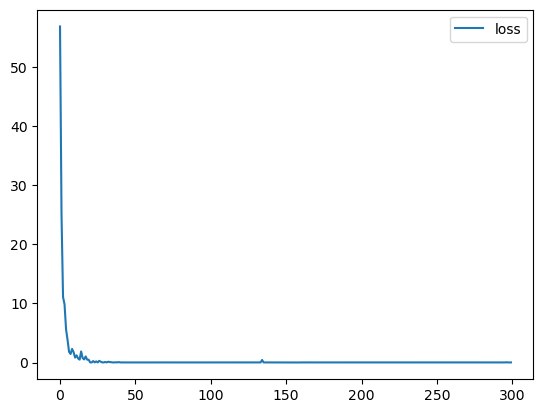

In [109]:
cfg = ScenarioGeneratorConfig(m, nBeforeBounds, nAfterBounds, variance)
backend_generator = new_backend_generator(new_scenario_generator(cfg))
# batch_generator = new_batch_generator(
#     backend_generator,
#     transform_backend_into_tensor_fn,
#     batch_size,
# )

model = NN(m).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
val_loss_fn = ValidityLoss()
dist_loss_fn = DistributionLoss()

total_params = sum(p.numel() for p in model.parameters())
print(f"model has {total_params} parameters")

start_time = time.time()
print("training model...")
loss_history = []
for epoch in range(epochs):
    # -- reset optimizer
    optimizer.zero_grad()

    # -- mean loss
    mean_loss = 0

    for i in range(batch_size):
        # -- generate inputs
        inputs = next(backend_generator)
        # -- run model
        outputs = model(inputs)
        # -- compute loss
        mean_loss += dist_loss_fn(outputs) + val_loss_fn(outputs)
        
    # -- propagate loss
    mean_loss /= batch_size
    mean_loss.backward()
    # -- append mean_loss to history & reset mean_loss
    loss = mean_loss.detach().numpy()
    loss_history.append(loss)

    # -- step
    optimizer.step()
        
    # -- log
    # -- display loss of current epoch.
    if epoch % 10 != 0 or epoch == epochs - 1:
        continue
    elapsed = datetime.timedelta(seconds=(time.time() - start_time))
    print(f"epoch {epoch+1}/{epochs}: loss={loss}, elapsed_time={elapsed}")

plt.plot(loss_history, label='loss')
plt.legend()
plt.show